# Introduction

<h1>RUAK - Are you a Hegel?</h1>

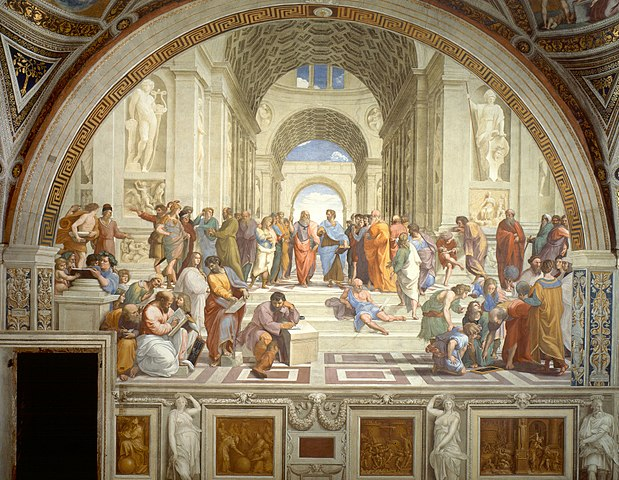

> The greatest challenge to any thinker is stating the problem in a way that will allow a solution.

<a href="https://en.wikipedia.org/wiki/Bertrand_Russell">Bertrand Russell</a>
<br><br>
<h2>About the project</h2>
Philosophy is a fundamental human thought movement. Everyone is a philosopher. The only question is what kind of philosopher you are. This project tries to answer that question.
Using natural language processing (NLP), texts of different authors are used for categorization.
With the help of these texts any sentence can be categorically determined.
To understand how written language works and what the differents are between authors it helps to analyse the context of the sentences. Though visualization it is simpler to see structural varieties such as average sentence length, word class ratio and the use of <a href="https://en.wikipedia.org/wiki/Stop_word">stop words</a>.
<br><br>
<h2>About this notebook</h2>
You can open this Jupyter notebook in Google Colab to use a GPU and have a nice platform for editing.
<br>
<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br>

<h2>Information on use</h2>
<h3>Paths:</h3>
The following data needs to be loaded. Please adjust the paths accordingly (1.2.1): 
<ul>
<li><code>source_path</code> - Path which contains the text files</li>
<li><code>dataframe_file_path</code> - Path for loading and saving the DataFrame</li>
<li><code>word2vec_model_file_path</code> - Path to Word2Vec model</li>
<li><code>hyperband_tuner_output_path</code> - Path to hyperparameter tuner working directory</li>
<li><code>model_h5_path</code> - Path where the model (h5 format) should be stored or loaded from</li>
</ul>
<br>
<h3>Speed:</h3>
Some processes may take a while depending on the settings and hardware requirements. To speed up the process, certain changes can be made. Obviously, the total amount of data also determines the overall speed. If possible try to use a machine with a GPU - like Google Colab!
<ul>
<li>The easiest way to speed up all processes is to switch to <code>test_mode</code> (1.2.1). This will have a strong impact on the results. Lemmatization and pos tagging is <b>not</b> disabled in <code>test_mode</code>.
<li>Adjust the parameters to fit your needs (1.2.1)
  <ul>
    <li><code>epochs</code> - Iterations for training</li>
    <li><code>search_epochs</code> - Iterations for finding the best hyperparameters</li>
    <li><code>executions_per_trial</code> - Number of models that should be built and fit for each trial for robustness purposes.</li>
  </ul>   
</li>
<li><code>hyperband_iterations</code> - The number of times to iterate over the full Hyperband algorithm.</li>
<li>POS tagging - this process uses Scad not be executedpy to tag every word in a sentence (4.2.1). Set <code>lemmatization_enabled</code> to <code>False</code> to skip it.</li>
<li>Prepare values for visualization (6.1.1.) - if <code>lemmatization_enabled</code> is set to <code>True</code> the list of unique vocabulary for each author is lemmatized. This will slow down the process.</li>
</ul>
<br>
<h2>Content</h2>

* [1. Preparations](#1)
* [2. Loading text data](#2)
* [3. Collect and clean data](#3)
* [4. Create and extend DataFrame](#4)
* [5. Store or load DataFrame](#5)
* [6. Visualization of data](#6)
* [7. Prepare and split](#7)
* [8. Hyperparameter tuning](#8)
* [9. Model preparation and training](#9)
* [10. Save or load model](#10)
* [11. Evaluation](#11)
* [12. TensorBoard](#12)






# 0. Google Colab

Mount Google Drive if needed

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

# 1. Preparations <a class="anchor" id="1"></a>

Pre-imports

In [ ]:
import os, datetime

## 1.1. Set variables and paths <a class="anchor" id="1-2-1"></a>

**This is the place where some information is needed. Please go though the steps and modify the information according to your needs.**

Set the language: `english` or `german`. For using German a custom Word2Vec model is needed. 

In [ ]:
language = 'english'

For tesing the notebook set `test_mode` to `True`. POS tagging and lemmatization will **not** be disabled.

In [ ]:
test_mode = False

Parameters needed for tuning and training. In test mode those parameters will be overwritten.

In [ ]:
batch_size=20
epochs=30
search_epochs=10
early_stopping_patience=5
executions_per_trial=1
hyperband_iterations=2

List of files to process and author names. Files should be named after author (e.g. `plato.txt`). `file_names` should contain at least 3 files.

In [ ]:
file_names = [
    'kant.txt', 
    'hume.txt', 
    'plato.txt', 
    'aristotle.txt',
    'nietzsche.txt'
    ]

Paths used for storing and loading. Should **never** end with `/` or file ending. To use weights from a custom Word2Vec model just fill in the path to the model (`word2vec_model_file_path`).

In [ ]:
source_path = os.path.abspath('../sample_sources')
dataframe_path = os.path.abspath('../output/dataframes')
tokenizer_json_path = os.path.abspath('../output/tokenizer')
word2vec_model_file_path = None
hyperband_tuner_output_path = os.path.abspath('../output/hp_tuning')
model_h5_path = os.path.abspath('../output/models')

Paths using Google Drive

In [ ]:
if 'google.colab' in str(get_ipython()):
  source_path = '/content/drive/My Drive/RUAK/sample_sources'
  dataframe_path = '/content/drive/My Drive/RUAK/output/dataframes'
  tokenizer_json_path = '/content/drive/My Drive/RUAK/output/tokenizer'
  word2vec_model_file_path = None
  hyperband_tuner_output_path = '/content/drive/My Drive/RUAK/output/hp_tuning'
  model_h5_path = '/content/drive/My Drive/RUAK/output/models'

Set min and max length for sentences

In [ ]:
min_length = 4
max_length = 150

Set `session_id` for providing unique file names

In [ ]:
session_id = datetime.datetime.now().strftime("%d/%m/%Y - %H:%M")

## 1.2. Installs and imports

Install Keras tuner, NLTK, and Spacy core.

In [ ]:
!rm -rf ./logs/

!pip install spacy
!pip install nltk
!pip install -q -U keras-tuner
!pip install tensorboard

import spacy.cli
if language == 'german':
  spacy.cli.download('de_core_news_md')
elif language == 'english':
  spacy.cli.download('en_core_web_md')
else:
  raise ValueError("'language' set to an invalid value!")

Additional downloads if not running on Google Colab. You may adjust this list.

In [ ]:
if 'google.colab' not in str(get_ipython()):
  !pip install tensorflow
  !pip install sklearn
  !pip install pandas
  !pip install matplotlib
  !pip install gensim
  !pip install wordcloud
  !pip install spacy

In [ ]:
import urllib, IPython, codecs, re, nltk, tensorboard, operator, random, json, \
  multiprocessing, gc
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, \
  Bidirectional, Dropout, BatchNormalization, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, \
  ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import kerastuner as kt
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from wordcloud import WordCloud
from collections import Counter
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy import displacy

if language == 'german':
  import de_core_news_md
  from spacy.lang.de.stop_words import STOP_WORDS
elif language == 'english':
  import en_core_web_md
  from spacy.lang.en.stop_words import STOP_WORDS
else:
  raise ValueError("'language' set to an invalid value!")

## 1.3. Magic functions

In [ ]:
%matplotlib inline
%load_ext tensorboard

## 1.4. Downloads for NLTK and Spacy

In [ ]:
nltk.download('punkt')
spacy.prefer_gpu()

if language == 'german':
  nlp = de_core_news_md.load()
elif language == 'english':
  nlp = en_core_web_md.load()
else:
  raise ValueError("'language' set to an invalid value!")

## 1.5 [Stop words](https://en.wikipedia.org/wiki/Stop_word)

In [ ]:
def replace_umlaut(string):
    string = string.replace('ä', 'ae')
    string = string.replace('ö', 'oe')
    string = string.replace('ü', 'ue')
    string = string.replace('Ä', 'Ae')
    string = string.replace('Ö', 'Oe')
    string = string.replace('Ü', 'Ue')
    return string.replace('ß', 'ss')

stop_words = set([replace_umlaut(word) for word in STOP_WORDS])
print(f'Stop words count: {len(stop_words)}.')

# 2. Loading text data <a class="anchor" id="2"></a>

In [ ]:
if len(file_names) < 3:
  raise ValueError("'file_names' should contain at least 3 files. Add more files at (1.2.1)!")

if test_mode == True:
  file_names = file_names[0:3]

for file_name in file_names:
  text_dir = tf.keras.utils.get_file(file_name, origin=f'file://{source_path}/{file_name}')

parent_dir = os.path.dirname(text_dir)

# 3. Collect and clean data <a class="anchor" id="3"></a>

## 3.1. Extract sentences

Extract sentences from files and creates labels list.

In [ ]:
labels = []
sentences = []

for index, file_name in enumerate(file_names):

  path = os.path.join(parent_dir, file_name)

  with codecs.open(path, 'rb', 'utf-8') as file: 
    text = str(file.read())
    nltk_sentences = nltk.sent_tokenize(text, language=language)

    for sentence in nltk_sentences:
      sentence = str(sentence).replace("b'", "")
      sentences.append(sentence)
      labels.append(index)

    print(f'Sentences for {file_name} with label: {index} added.')

print(f'\n{len(sentences)} sentences found.')

## 3.2. Clean data

Removes all not wanted characters from the texts. Add more rules if needed.

In [ ]:
def clean_up(text):
    text = text.replace(' ', ' ')
    text = text.replace('–', '-')
    text = text.replace('\n', ' ')
    text = re.sub(r'[IVXLCDM]+\.', '', text)
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'\((.*?)\)', '', text)
    text = re.sub(r'\{(.*?)\}', '', text)
    text = re.sub(r'\b[A-Z]{2,}\b', '', text)
    text = text.replace(' ,', ',')
    text = text.replace(' .', '.')
    text = text.replace(' ;', ';')
    text = re.sub(r'[^A-Za-z0-9äÄöÖüÜß\s\.\-\!\?\:\;\,]', '', text)
    text = re.sub(r' +', ' ', text)
    text = text.replace('ä', 'ae')
    text = text.replace('ö', 'oe')
    text = text.replace('ü', 'ue')
    text = text.replace('Ä', 'Ae')
    text = text.replace('Ö', 'Oe')
    text = text.replace('Ü', 'Ue')
    text = text.replace('ß', 'ss')
    text = re.sub(r' +', ' ', text)
    return text

In [ ]:
pre_cleaned_sentences = [clean_up(sentence) for sentence in sentences]

In [ ]:
def short_sentences(length):
  short_sentences = [sentence for sentence in pre_cleaned_sentences if len(sentence.split()) <= length]
  print(f'Found {len(short_sentences)} sentences shorter than {length} words.\n')
  return short_sentences

def long_sentences(length):
  long_sentences = [sentence for sentence in pre_cleaned_sentences if len(sentence.split()) >= length]
  print(f'Found {len(long_sentences)} sentences longer than {length} words.\n')
  return long_sentences

### 3.2.1. Remove sentences

Get invalid sentences

In [ ]:
invalid_sentences = short_sentences(min_length) + long_sentences(max_length)
print(f'Found {len(invalid_sentences)} invalid sentences.')

#### 3.2.1.1. Investigate invalid sentences
Print 5 examples of `invalid_sentences`

In [ ]:
for i in random.sample(range(10, len(invalid_sentences)-1), 10):
  print(invalid_sentences[i])

Use Spacy [Visualizer](https://spacy.io/usage/visualizers) to show a random invalid sentence.

In [ ]:
if tf.test.gpu_device_name() == '': # Needed to avoid chash in Spacy when running a GPU.
  doc = nlp(invalid_sentences[random.randint(0, len(invalid_sentences)-1)])
  displacy.render(doc, style="dep", jupyter=True, options={'compact':'True'})

### 3.2.2. Provide cleaned data

In [ ]:
cleaned_labels = []
cleaned_sentences = []
print(f"'sentences' list length before removal: {len(pre_cleaned_sentences)}.")
for index, sentence in enumerate(pre_cleaned_sentences):
  if sentence not in invalid_sentences:
    cleaned_sentences.append(sentence)
    cleaned_labels.append(labels[index])  
print(f"'sentences' list length after removal: {len(cleaned_sentences)}.")
print(f'{len(invalid_sentences)} sentences removed.')

Print longest valid sentence

In [ ]:
print(max(cleaned_sentences, key=len))

Use Spacy [Visualizer](https://spacy.io/usage/visualizers) to show the longest valid sentence.

In [ ]:
if tf.test.gpu_device_name() == '': # Needed to avoid chash in Spacy when running a GPU.
  doc = nlp(max(cleaned_sentences, key=len))
  displacy.render(doc, style="dep", jupyter=True, options={'compact':'True'})

# 4. Create and extend DataFrame <a class="anchor" id="4"></a>

Some helper methods

In [ ]:
def stop_word_ratio_fn(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in stop_words:
      count += 1
  return round(count/len(sentence.split()) * 100, 2)

def stop_word_count_fn(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in stop_words:
      count += 1
  return count

def mean_word_length_fn(sentence):
  return round(np.array([len(word) for word in sentence.replace('.','').split()]).mean(), 2)

def pos_count(sentence, pos):
  doc = nlp(sentence)
  return len([w.pos_ for w in doc if w.pos_ == pos])

## 4.1. Create DataFrame

In [ ]:
df = pd.DataFrame({'label': cleaned_labels, 'sentence': cleaned_sentences})
df.head()

## 4.2. Construct new data

In [ ]:
author_names = [name[:-4].capitalize() for name in file_names]

In [ ]:
df['author'] = df['label'].map(lambda x: author_names[x])
df['word_count'] = df['sentence'].str.split().str.len()
df['mean_word_length'] = df['sentence'].map(mean_word_length_fn)
df['stop_words_ratio'] = df['sentence'].map(stop_word_ratio_fn)
df['stop_words_count'] = df['sentence'].map(stop_word_count_fn)

### 4.2.1. POS tagging <a class="anchor" id="4-2-*1*"></a>
Add columns and values for [POS tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging).A list of tags can be found [here](https://spacy.io/api/annotation). **This may take a while!**

In [ ]:
pos_tagging_enabled = True

In [ ]:
if pos_tagging_enabled == True:
  pos_tags = {'ADJ':'adjective', 'ADV':'adverb', 'ADP':'adposition', 
              'AUX':'auxiliary', 'DET':'determiner', 'NUM':'numeral', 
              'X':'other', 'INTJ':'interjection', 'CONJ':'conjunction', 
              'CCONJ':'coord. conjunction', 'SCONJ':'subord. conjunction', 
              'PROPN':'proper noun', 'NOUN':'noun', 'PRON':'pronoun', 
              'PART':'particle', 'VERB':'verb'}
            
  for tag in list(pos_tags.keys()):
    df[f'{tag}_count'] = df['sentence'].map(lambda sen: pos_count(sen, tag))

## 4.3. Preview processed DataFrame

In [ ]:
df.head(df.shape[0])

# 5. Store or load DataFrame <a class="anchor" id="5"></a>

Save DataFrame to CSV if needed.

In [ ]:
if test_mode == False:
  file_path = f'{dataframe_path}/ruak_dataframe.csv'
else: 
  file_path = f'{dataframe_path}/ruak_dataframe_testing.csv'  

df.to_csv(file_path, index=False)
print(f'DataFrame saved to: {file_path}.')

Save to HDF5

In [ ]:
if test_mode == False:
  df.to_hdf(f'{dataframe_path}/ruak_dataframe.h5', key='df', mode='w')

Load the DataFrame from CSV if needed.

In [ ]:
if test_mode == False:
  file_path = f'{dataframe_path}/ruak_dataframe.csv'
else: 
  file_path = f'{dataframe_path}/ruak_dataframe_testing.csv'  

df = pd.read_csv(file_path)
print(f'Shape: {df.shape}')
df.head()

# 6. Visualization of data <a class="anchor" id="6"></a>

## 6.1 Prepare values for visualization

Prepare values for visualization. Enable [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) to get more a more prezise `unique_vocabulary_count`, `words_without_stop_words`, and `most_common`. **This will slow down the process!**

In [ ]:
lemmatization_enabled = False

In [ ]:
def lemmatize(sentence):
  words = set()
  doc = nlp(sentence)
  for word in doc:
    words.add(word.lemma_)
  return list(words)

Helper functions

In [ ]:
def vocabulary_count_fn(series, lemmatization):
  vocabulary = set()
  for sentence in series:
    if lemmatization == True:
      words = lemmatize(sentence)
    else:
      words = sentence.split()  
    for word in words:
      if word.lower() not in stop_words and word is not '':
        word = re.sub(r'[^a-zA-Z]+', '', word)
        vocabulary.add(word.lower())
  return len(vocabulary)

In [ ]:
def non_stop_words_vocab(sentences):
  words_without_stop_words = []
  for sentence in sentences:
    for word in sentence.split():
      word = re.sub(r'[^a-zA-Z]+', '', word)
      if word.lower() not in stop_words and word is not '':
        words_without_stop_words.append(word)
  return words_without_stop_words

In [ ]:
words_without_stop_words = non_stop_words_vocab(df['sentence'].values)
most_common = [word[0] for word in Counter(words_without_stop_words).most_common(20)]
most_common_count = {key: value for key, value in Counter(words_without_stop_words).most_common(20)}

### 6.1.1. Prepare values for visualization <a class="anchor" id="6-1-1"></a>

In [ ]:
author_names = df['author'].unique()
median_sentence_length = df.groupby('author')['word_count'].median()
mean_word_length = df.groupby('author')['mean_word_length'].mean()
median_stop_words = df.groupby('author')['stop_words_ratio'].median()
author_sentence_count = df.groupby('author')['sentence'].count()
author_unique_vocabulary_count = df.groupby('author')['sentence'] \
  .apply(lambda ser: vocabulary_count_fn(ser, lemmatization_enabled))

Create POS tag data frame if tags are available in dataframe

In [ ]:
if 'ADJ_count' in df:
  pos_tags = {'ADJ':'adjective', 'ADV':'adverb', 'ADP':'adposition', 
              'AUX':'auxiliary', 'DET':'determiner', 'NUM':'numeral', 
              'X':'other', 'INTJ':'interjection', 'CONJ':'conjunction', 
              'CCONJ':'coord. conjunction', 'SCONJ':'subord. conjunction', 
              'PROPN':'proper noun', 'NOUN':'noun', 'PRON':'pronoun', 
              'PART':'particle', 'VERB':'verb'}

  pos_df = df.groupby('author') \
  [[f'{tag}_count' for tag in list(pos_tags.keys())]+['word_count']] \
  .sum().apply((lambda x: x/x['word_count']*100), axis=1) \
  .drop('word_count', axis=1)

## 6.2. Draw visualization

Set matplotlib style

In [ ]:
plt.style.use('fivethirtyeight') 

### 6.2.1 Data distribution
The data should be equally split between authors.

In [ ]:
plt.pie(df['author'].value_counts(),
        explode=np.full(len(author_names), 0.1),
        radius=2,
        autopct='%1.0f%%', 
        labels=author_names,
        shadow=True,
        startangle=90,
        textprops={'size': 15})
plt.show()

### 6.2.2. Comparing authors

Draw distribution of word lengths by author

In [ ]:
vocab_length = df.groupby('author')['sentence'] \
  .apply(' '.join) \
  .apply (lambda x: re.sub(r"[^a-zA-Z\s]+", "", x).lower()) \
  .apply(lambda x: [len(word) for word in x.split() \
   if word not in stop_words])

voc_list = []
for i in range(len(author_names)):
  voc_list.append(vocab_length[i])

plt.figure(figsize=(15,7))
plt.hist(voc_list, bins=10, alpha=0.8, range=(0,20), log=True)
plt.xlabel('Length of word')
plt.ylabel('Word count')
plt.legend(labels=author_names)
plt.show()

In [ ]:
sent_length = df.groupby('author')['word_count'].apply(lambda x: x.values)

sent_list = []
for i in range(len(author_names)):
  sent_list.append(sent_length[i])

plt.figure(figsize=(15,7))
plt.hist(sent_list, bins=20, alpha=0.8, range=(min_length, max_length), log=True)
plt.xlabel('Length of sentence')
plt.ylabel('Sentence count')
plt.legend(labels=author_names)
plt.show()

Compate different metrics between authors

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,15))
fig.tight_layout()

axs[0].bar(author_names, author_sentence_count, alpha=0.7)
axs[0].set_ylabel('Number of sentences')

axs[1].bar(author_names, median_sentence_length, alpha=0.7)
axs[1].set_ylabel('Median sentence lenth')

axs[2].bar(author_names, mean_word_length, alpha=0.7)
axs[2].set_ylabel('Mean word length')

axs[3].bar(author_names, author_unique_vocabulary_count, alpha=0.7)
axs[3].set_ylabel('Unique vocabulary count\n(excl. stop words)')

axs[4].bar(author_names, median_stop_words, alpha=0.7)
axs[4].set_ylabel('Median stop words ratio')

plt.show()

Word classes by authors. A list of tags can be found [here](https://spacy.io/api/annotation).

In [ ]:
if 'pos_df' in locals() and 'pos_tags' in locals():
  ax = pos_df.plot(kind='barh', figsize=(15,15), alpha=0.8)
  ax.set_xlabel('Percentage of word class in vocabulary')
  ax.set_ylabel('Author')
  ax.legend(pos_tags.values())
  ax.xaxis.set_tick_params(labeltop='on')
  plt.show()
else:
  print("Error: 'pod_df' or 'pos_tags' not available!") 

### 6.2.3. Common words

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(most_common_count.keys(), 
        most_common_count.values(), 
        color='orange', 
        alpha=0.8)

plt.ylabel('Number of sentences')
plt.show()

### 6.2.4. Sentences by authors
This shows the sentence structure, lemmas, and pos tags of one random sentences from each author.

In [ ]:
if tf.test.gpu_device_name() == '': # Needed to avoid chash in Spacy when running a GPU.
  for author in author_names:
    sentences_series = df.loc[(df['author'] == author) & 
                              (df['sentence'].str.len() < 50)]['sentence']
    print(f'\nSentence by {author}:')
    doc = nlp(sentences_series.sample(n=1).values[0])
    displacy.render(doc, 
                    style="dep", 
                    jupyter=True, 
                    options={'compact':'True', 'add_lemma': 'True'})

### 6.2.5. Word cloud

In [ ]:
wordcloud_size = 60
wordcloud_words = {k: v for k, v in Counter(words_without_stop_words).most_common(wordcloud_size)}
wordcloud = WordCloud(width=5000, 
                      height=4000,
                      max_words=wordcloud_size,  
                      background_color ='black', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate_from_frequencies(wordcloud_words) 

plt.figure(figsize=(20, 12), facecolor='k', edgecolor ='k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show() 

# 7. Prepare and split <a class="anchor" id="7"></a>

## 7.1. Tokenize

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentence'].values)
print(f"{len(df['sentence'].values)} sentences from {len(file_names)} authors.")
print(f'{len(tokenizer.word_counts)} unique vocabularies tokenized.')

Store the tokenizer configuration to a JSON file

In [ ]:
json = tokenizer.to_json()
if test_mode == True:
  path = f'{tokenizer_json_path}/tok_config_test.txt'
else:
  path = f'{tokenizer_json_path}/tok_config.txt'

with open(path, 'w') as file:
    file.write(json)

## 7.2. Encode

In [ ]:
encoded_sentences = tokenizer.texts_to_sequences(df['sentence'].values)
padded_sentences = pad_sequences(encoded_sentences, padding='post')
print(f"{len(padded_sentences)} sentences padded.")

## 7.3. Create new data frames

### 7.3.1. Padded sentence data frame

Create a new data frame which contains only the `patted_sentences` and the labels

In [ ]:
padded_sentence_df = pd.DataFrame(padded_sentences, 
                                  columns=[f'loc_{i}' for i in range(len(padded_sentences[0]))])
padded_sentence_df['label'] = df['label']

Remove the rows where the fist column is a 0.

In [ ]:
padded_sentence_df.drop(padded_sentence_df[padded_sentence_df.loc_0 == 0].index, inplace=True)

Preview the padded sentences data frame

In [ ]:
padded_sentence_df.head()

Test the encoder

In [ ]:
print(df['sentence'].values[0])
print(padded_sentence_df.iloc[0].values)
print(tokenizer.sequences_to_texts([padded_sentence_df.iloc[0].values]))

### 7.3.2. Metadata data frame 

Create a new data frame which contains normalized metadata of the sentence

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(df.drop({'sentence', 'author', 'label'}, 
                                              axis=1).values)
metadata_df = pd.DataFrame(scaled)
metadata_df['label'] = df['label']

Preview the normalized data frame

In [ ]:
metadata_df.head()

## 7.4. Splitting
Create train and test data for the fitting proccess.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(padded_sentence_df.drop('label', axis=1).values, 
                                                      padded_sentence_df['label'].values, test_size=0.1)

print(f'Shape of the splited X_train: {X_train.shape}')
print(f'Shape of the splited y_train: {y_train.shape}')
print(f'Shape of the splited X_valid: {X_valid.shape}')
print(f'Shape of the splited y_valid: {y_valid.shape}')

# 8. Hyperparameter tuning <a class="anchor" id="8"></a>

## 8.1. Setup the hypermodel

### 8.1.1. Load the Word2Vec model
For german the custom Word2Vec layer is used.

In [ ]:
def embedding_matrix_custom():
  model = Word2Vec.load(word2vec_model_file_path)
  embedding_matrix = np.zeros((len(model.wv.vocab), model.vector_size))
  for i in range(len(model.wv.vocab)):
      embedding_vector = model.wv[model.wv.index2word[i]]
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

For English we use [Wiki-words-250](https://tfhub.dev/google/Wiki-words-250/2) provided by Tensorflow Hub.

In [ ]:
def embedding_matrix_hub():
    hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250/2", input_shape=[], dtype=tf.string)
    return hub_layer.get_weights()[0]


In [ ]:
if word2vec_model_file_path is not None:
  embeddings = embedding_matrix_custom()
elif language == 'english':
  embeddings = embedding_matrix_hub()
else:
  raise ValueError("""
    Something went wrong! Seems like you picked German but did not provide a 
    'word2vec_model_file_path'. The downloaded Word2Vec model only supports
    English. So either change the language to English or provide a path for the model.
  """)

print(f'Embeddings shape: {embeddings.shape}')

### 8.1.2. Define the hypermodel

Collection of hyperparameters

In [ ]:
def hyperparameter_dict(hp):
  if test_mode == False:
    return {
      'dense_units_count': hp.Int(f'dense_units_count', 128, 512, step=128),
      'lstm_units_count': hp.Int('lstm_units_count', 64, 256, step=64),
      'dropout_rate': hp.Choice('dropout_rate', [0.25, 0.5]),
      'learning_rate': hp.Choice('learning_rate', [0.001, 0.0001]),
      'adam_epsilon': hp.Choice('adam_epsilon', [1e-07, 1e-08])
    }

  return {
    'dense_units_count': hp.Int(f'dense_units_count', 64, 128, step=64),
    'lstm_units_count': hp.Int('lstm_units_count', 32, 64, step=32),
    'dropout_rate': hp.Choice('dropout_rate', [0.25]),
    'learning_rate': hp.Choice('learning_rate', [0.001]),
    'adam_epsilon': hp.Choice('adam_epsilon', [1e-08])
  }

Model definition

In [ ]:
def hypermodel(hp):
  hyp = hyperparameter_dict(hp)

  input = Input(shape=(X_train.shape[1],))

  x = Embedding(len(embeddings),
            output_dim=embeddings.shape[1],
            weights=[embeddings], 
            trainable=False,
            mask_zero=True)(input)

  x = Bidirectional(LSTM(hyp['lstm_units_count'], return_sequences=False))(x)
  x = BatchNormalization()(x)  
  x = Dropout(hyp['dropout_rate'])(x)
  x = Dense(hyp['dense_units_count'], activation='relu')(x)

  predictions = Dense(len(file_names), activation='softmax')(x)

  model = Model(inputs=input, outputs=predictions)
  
  model.compile(optimizer=optimizers.Adam(learning_rate=hyp['learning_rate'], epsilon=hyp['adam_epsilon']),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

## 8.2. Prepare and run the tuner
Reduce parameters for `testing_mode`

In [ ]:
if test_mode == True:
  epochs=4
  search_epochs=1
  early_stopping_patience=4
  executions_per_trial=1
  hyperband_iterations=1

Set variables

In [ ]:
max_epochs = epochs+5
project_name = 'RUAK'
if test_mode == True:
  max_epochs = 1
  project_name = 'RUAK_testing'

Prepare the hyperband tuner

In [ ]:
tuner = kt.Hyperband(hypermodel,
                     objective='val_accuracy', 
                     executions_per_trial=executions_per_trial,
                     max_epochs=max_epochs,
                     hyperband_iterations=hyperband_iterations,
                     directory=hyperband_tuner_output_path,
                     project_name=project_name,
                     overwrite=True)

Run the tuner to search for best parameters. The result are the optimal hyperparameters: `best_hps` and a list of `best_models`.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait=True)

class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

tuner.search(X_train, y_train, 
            epochs=search_epochs,
            validation_data=(X_valid, y_valid),
            batch_size=batch_size,
            callbacks=[ClearTrainingOutput(), 
                       GarbageCollectorCallback(), 
                       EarlyStopping('val_accuracy', patience=1)],
            use_multiprocessing=True,
            workers=multiprocessing.cpu_count(),
            verbose=1)

best_hps = tuner.get_best_hyperparameters(1)[0]
best_models = tuner.get_best_models(num_models=3)

tuner.results_summary()

# 9. Model preparation and training <a class="anchor" id="9"></a>

Get summaries of the best models and choose the model for training.

In [ ]:
for model in best_models:
  model.summary()

Choose preferred model

In [ ]:
chosen_model = best_models[0]
del best_models
gc.collect()

Plot model structure

In [ ]:
plot_model(chosen_model, show_shapes=True, show_layer_names=True)

## 9.1. Prepare callbacks
TensorBoard preparation

In [ ]:
log_dir = os.path.join('logs', session_id)
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Create `EarlyStopping` callback

In [ ]:
es_callback = EarlyStopping('val_accuracy', patience=early_stopping_patience, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(factor=0.5, patience=2,  verbose=0, min_lr=1e-10)

## 9.2. Model training

In [ ]:
h = chosen_model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_valid, y_valid), 
                      callbacks=[es_callback, 
                                 tb_callback, 
                                 reduce_lr_callback, 
                                 GarbageCollectorCallback],
                      use_multiprocessing=True,
                      workers=multiprocessing.cpu_count(),
                      verbose=2)

# 10. Save or load model <a class="anchor" id="10"></a>

## 10.1. Save model

In [ ]:
if test_mode == False:
  model.save(f'{model_h5_path}/ruak_model.h5')

## 10.2. Load model

In [ ]:
if test_mode == False:
  chosen_model = tf.keras.models.load_model(f'{model_h5_path}/ruak_model.h5')

# 11. Evaluation <a class="anchor" id="11"></a>

Draw charts to show compare training and validation results

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(8, 6))

epochs = range(len(h.history['accuracy']))
axs[0].plot(epochs, h.history['accuracy'], color='red', marker='x')
axs[0].plot(epochs, h.history['val_accuracy'], color='green', marker='.')
axs[0].legend(labels=['Training accuracy','Validation accuracy'])
axs[0].set_ylabel('Accuracy', fontdict={'color':'gray', 'size':12})
axs[0].tick_params(labelbottom=False)
axs[0].grid()

epochs = range(len(h.history['loss']))
axs[1].plot(epochs, h.history['loss'], color='red', marker='x')
axs[1].plot(epochs, h.history['val_loss'], color='green', marker='.')
axs[1].legend(labels=['Training loss','Validation loss'])
axs[1].set_ylabel('Loss', fontdict={'color':'gray', 'size':12})
axs[1].tick_params(labelbottom=False)
axs[1].grid()

plt.show()

Show loss and accuracy

In [ ]:
val_loss, val_acc = chosen_model.evaluate(X_valid)
print(f'Validation Accuracy: {val_acc}')
print(f'Validation Loss: {val_loss}')

## 11.1. Test the model

Test the model. Add  `sample_sentences` to get the probability distribution for each author.

In [ ]:
sample_sentences = [
                    # 0 - Platon
                    "Das ziemt uns ja auch nicht, Sokrates",
                    # 1 - Nietzsche
                    "Noch hat er seine that nicht ueberwunden.", 
                    # 2 - Kant
                    "Die Grenzen der Ausdehnung bestimmen die Figur."
                   ]

# Add your own sentences:
# sample_sentences = ["Here you can try your own sentences.", "Let's see what kind of philosopher you are."]

Load tokenizer if needed

In [ ]:
if 'tokenizer' not in locals():
  with open(tokenizer_json_path, 'r') as file:
    data = file.read()
    json_string = json.loads(data)

  new_tokenizer = Tokenizer()
  tokenizer = new_tokenizer.tokenizer_from_json(json_string)

In [ ]:
encoded_sample_sentences = tokenizer.texts_to_sequences(sample_sentences)
padded_sample_sentences = pad_sequences(encoded_sample_sentences, maxlen=X_train.shape[1], padding='post')
predictions = model.predict(padded_sample_sentences)

predictions_df = pd.DataFrame()
for index, prediction in enumerate(predictions):
  for i, pre in enumerate(prediction):
    predictions_df = predictions_df.append({
      'sentence_number': index,
      'author': author_names[i],
      'prediction': pre,
      'sentence': sample_sentences[index]
    }, ignore_index=True)

predictions_df.head(predictions_df.shape[0])

Draw bars for each sample sentence

In [ ]:
fig, axs = plt.subplots(len(predictions), 1, figsize=(10,10))
fig.tight_layout(h_pad=6)
for sen_id, pre in enumerate(predictions):
  for i, p in enumerate(pre):
    axs[sen_id].barh(author_names, pre)
    axs[sen_id].set_title(f'Sentence {sen_id}: {sample_sentences[sen_id][0:70]}...'})
    axs[sen_id].set_ylabel('Author')
    axs[sen_id].set_xlabel('Probability')    
    axs[sen_id].grid()

plt.show()

# 12. TensorBoard <a class="anchor" id="12"></a>

In [ ]:
%tensorboard --logdir logs

Clean TensorBoad logs

In [ ]:
!rm -rf ./logs/